> Simulation

<a href="https://colab.research.google.com/github/miruetoto/yechan3/blob/main/posts/3_Researches/STGCN/2022-12-29-STGCN-tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt=""></a>

# About this doc 

`-` 이 문서는 공식홈페이지의 예제와 최서연학생의 블로그 내용을 재구성하여 만듬 

`-` 이 문서의 목표는 아래와 같다. 

- STGCN을 사용할 수 있는 데이터의 형태를 탐구한다.
- STGCN을 실습할 코드를 확보한다. 

`-` 코랩에서 실습하기 위해서는 아래를 설치해야한다. 

In [ ]:
!pip install torch-geometric
!pip install torch-geometric-temporal

# ref 

- [PyG 공식홈페이지](https://pytorch-geometric.readthedocs.io/en/latest/index.html#) // `torch_geometric`
- [PyTorch Geometric Temporal 공식홈페이지](https://pytorch-geometric-temporal.readthedocs.io/en/latest/index.html) // `torch_geometric_temporal`
- [최서연 블로그](https://github.com/seoyeonc/blog/blob/main/posts/GCN/2022-12-21-st-gcn%20Dataset.ipynb)

참고: `torch` 를 기반으로 `PyG`^[일반적인 기하학적 딥러닝을 위한 파이토치 패키지]이 만들어 졌고 `PyG`를 기반으로 `PyTorch Geometric Temporal`^[STGCN을 위한 패키지]가 만들어짐. 

# imports 

`-` 필요한 패키지 임포트

In [1]:
# 일반적인 모듈 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 
from tqdm import tqdm 

# 파이토치 관련 
import torch
import torch.nn.functional as F

# PyG 관련 
from torch_geometric.data import Data

# STGCN 관련 
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split 

- `tdqm`: for문의 진행상태를 확인하기 위한 패키지
- `networkx`: 그래프 시그널 시각화를 위한 모듈 
- `torch`: 파이토치 (STGCN은 파이토치 기반으로 만들어짐) 모듈
- `torch.nn.functional`: relu 등의 활성화함수를 불러오기 위한 모듈
- `Data`: 그래프자료를 만들기 위한 클래스
- `GConvGRU`: STGCN layer를 만드는 클래스
- `temporal_signal_split`: STGCN dataset 을 train/test 형태로 분리하는 기능이 있는 "함수" 

`-` STGCN의 학습을 위한 클래스선언 

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# notaions ofr STGCN

`-` 시계열: each $t$ 에 대한 observation이 하나의 값 (혹은 벡터) 

- 자료: $X(t)$ for $t=1,2,\dots,T$

`-` STGCN setting에서는 each $t$ 에 대한 observation이 graph

- 자료: $X(v,t)$ for $t=1,2,\dots,T$ and $v \in V$
- 주의: 이 포스트에서는 $X(v,t)$ 를 $f(v,t)$ 로 표현할 때가 있음 


# dataset, dataloaders

## PyG 의 Data 자료형 

> ref: <https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs>

`-` 자료는 [PyG의 Data 오브젝트](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs)를 기반으로 한다. 



(예제) 아래와 같은 그래프자료를 고려하자. 

![](https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg)

이러한 자료형은 아래와 같은 형식으로 저장한다. 

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index) # Data는 그래프자료형을 만드는 클래스

In [4]:
type(data)

torch_geometric.data.data.Data

In [5]:
data.x

tensor([[-1.],
        [ 0.],
        [ 1.]])

In [6]:
data.edge_index

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])

## PyTorch Geometric Temporal 의 자료형 

> ref: [PyTorch Geometric Temporal Signal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/signal.html#torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal)

아래의 클래스들중 하나를 이용하여 만든다. 

```Python
## Temporal Signal Iterators
torch_geometric_temporal.signal.StaticGraphTemporalSignal
torch_geometric_temporal.signal.DynamicGraphTemporalSignal
torch_geometric_temporal.signal.DynamicGraphStaticSignal
## Heterogeneous Temporal Signal Iterators
torch_geometric_temporal.signal.StaticHeteroGraphTemporalSignal
torch_geometric_temporal.signal.DynamicHeteroGraphTemporalSignal
torch_geometric_temporal.signal.DynamicHeteroGraphStaticSignal
```

이중 "Heterogeneous Temporal Signal" 은 우리가 관심이 있는 신호가 아니므로 사실상 아래의 3개만 고려하면 된다. 

- `torch_geometric_temporal.signal.StaticGraphTemporalSignal`
- `torch_geometric_temporal.signal.DynamicGraphTemporalSignal`
- `torch_geometric_temporal.signal.DynamicGraphStaticSignal`

여기에서 `StaticGraphTemporalSignal` 는 시간에 따라서 그래프 구조가 일정한 경우, 즉 ${\cal G}_t=\{{\cal V},{\cal E}\}$와 같은 구조를 의미한다. 

**(예제1)** StaticGraphTemporalSignal 를 이용하여 데이터 셋 만들기 

`-` json data $\to$ dict 

In [7]:
import json
import urllib

In [8]:
url = "https://raw.githubusercontent.com/benedekrozemberczki/pytorch_geometric_temporal/master/dataset/chickenpox.json"
data_dict = json.loads(urllib.request.urlopen(url).read())
# data_dict 출력이 김

In [9]:
data_dict.keys()

dict_keys(['edges', 'node_ids', 'FX'])

`-` 살펴보기 

In [10]:
np.array(data_dict['edges']).T

array([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15,
        15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18,
        18, 18, 19, 19, 19, 19],
       [10,  6, 13,  1,  0,  5, 16,  0, 16,  1, 14, 10,  8,  2,  5,  8,
        15, 12,  9, 10,  3,  4, 13,  0, 10,  2,  5,  0, 16,  6, 14, 13,
        11, 18,  7, 17, 11, 18,  3,  2, 15,  8, 10,  9, 13,  3, 12, 10,
         5,  9,  8,  3, 10,  2, 13,  0,  6, 11,  7, 13, 18,  3,  9, 13,
        12, 13,  9,  6,  4, 12,  0, 11, 10, 18, 19,  1, 14,  6, 16,  3,
        15,  8, 16, 14,  1,  0,  6,  7, 19, 17, 18, 14, 18, 17,  7,  6,
        19, 11, 18, 14, 19, 17]])

- ${\cal E} = \{(0,10),(0,6), \dots, (19,17)\}$
- 혹은  ${\cal E} = \{(\tt{BACS},\tt{JASZ}), ({\tt BACS},{\tt FEJER}), \dots, (\tt{ZALA},\tt{VAS})\}$

In [11]:
data_dict['node_ids']

{'BACS': 0,
 'BARANYA': 1,
 'BEKES': 2,
 'BORSOD': 3,
 'BUDAPEST': 4,
 'CSONGRAD': 5,
 'FEJER': 6,
 'GYOR': 7,
 'HAJDU': 8,
 'HEVES': 9,
 'JASZ': 10,
 'KOMAROM': 11,
 'NOGRAD': 12,
 'PEST': 13,
 'SOMOGY': 14,
 'SZABOLCS': 15,
 'TOLNA': 16,
 'VAS': 17,
 'VESZPREM': 18,
 'ZALA': 19}

- ${\cal V}=\{\tt{BACS},\tt{BARANYA} \dots, \tt{ZALA}\}$

In [12]:
np.array(data_dict['FX']), np.array(data_dict['FX']).shape

(array([[-1.08135724e-03, -7.11136085e-01, -3.22808515e+00, ...,
          1.09445310e+00, -7.08747750e-01, -1.82280792e+00],
        [ 2.85705967e-02, -5.98430173e-01, -2.29097341e-01, ...,
         -1.59220988e+00, -2.24597623e-01,  7.86330575e-01],
        [ 3.54742090e-01,  1.90511208e-01,  1.61028185e+00, ...,
          1.38183225e-01, -7.08747750e-01, -5.61724314e-01],
        ...,
        [-4.75512620e-01, -1.19952837e+00, -3.89043358e-01, ...,
         -1.00023329e+00, -1.71429032e+00,  4.70746677e-02],
        [-2.08645035e-01,  6.03766218e-01,  1.08216835e-02, ...,
          4.71099041e-02,  2.45684924e+00, -3.44296107e-01],
        [ 1.21464875e+00,  7.16472130e-01,  1.29038982e+00, ...,
          4.56939849e-01,  7.43702632e-01,  1.00375878e+00]]),
 (521, 20))

- ${\bf f}=\begin{bmatrix}
{\bf f}_1\\
{\bf f}_2\\
\dots \\
{\bf f}_{521}
\end{bmatrix}=\begin{bmatrix}
f(t=1,v=\tt{BACS}) & \dots & f(t=1,v=\tt{ZALA}) \\
f(t=2,v=\tt{BACS}) & \dots & f(t=2,v=\tt{ZALA}) \\
\dots & \dots & \dots \\
f(t=521,v=\tt{BACS}) & \dots & f(t=521,v=\tt{ZALA}) 
\end{bmatrix}$ 

즉 data_dict는 아래와 같이 구성되어 있음 

|수학 기호|코드에 저장된 변수| 자료형 | 차원 | 설명 | 
|:-:|:-:|:-:|:-:|:-:|
|${\cal V}$|`data_dict['node_ids']`|dict|20| 20개의 노드에 대한 설명이 있음|
|${\cal E}$|`data_dict['edges']`|list (double list)|(102,2) | 노드들에 대한 102개의 연결을 정의함 |
|${\bf f}$|`data_dict['node_ids']`|dict|(521,20)| $f(t,v)$ for $v \in {\cal V}$ and $t = 1,\dots, T$ | 

`-` 주어진 자료를 정리하여 그래프신호 $\big(\{{\cal V},{\cal E},{\bf W}\},{\bf f}\big)$를 만들면 아래와 같다. 

In [13]:
edges = np.array(data_dict["edges"]).T
edge_weight = np.ones(edges.shape[1])
f = np.array(data_dict["FX"])

- 여기에서 `edges`는 ${\cal E}$에 대한 정보를 
- `edges_weight`는 ${\bf W}$에 대한 정보를
- `f`는 ${\bf f}$에 대한 정보를 저장한다. 

> Note: 이때 ${\bf W}={\bf E}$ 로 정의한다. (하지만 꼭 이래야 하는건 아니야)

`-` `data_dict` $\to$ `dl`

In [14]:
lags = 4
features = [f[i : i + lags, :].T for i in range(f.shape[0] - lags)]
targets = [f[i + lags, :].T for i in range(f.shape[0] - lags)]

In [15]:
np.array(features).shape, np.array(targets).shape

((517, 20, 4), (517, 20))

|설명변수|반응변수|
|:-:|:-:|
|${\bf X} = {\tt features} = \begin{bmatrix} 
{\bf f}_1 & {\bf f}_2 & {\bf f}_3 & {\bf f}_4 \\ {\bf f}_2 & {\bf f}_3 & {\bf f}_4 & {\bf f}_5 \\ \dots & \dots & \dots & \dots \\ {\bf f}_{517} & {\bf f}_{518} & {\bf f}_{519} & {\bf f}_{520} \end{bmatrix}$|${\bf y}= {\tt targets} = \begin{bmatrix} {\bf f}_5 \\ {\bf f}_6 \\ \dots \\ {\bf f}_{521} \end{bmatrix}$|

- AR 느낌으로 표현하면 AR(4) 임 

In [16]:
dataset = torch_geometric_temporal.signal.StaticGraphTemporalSignal(
    edge_index= edges,
    edge_weight = edge_weight,
    features = features,
    targets = targets
)

In [17]:
dataset

`-` 그런데 이 과정을 아래와 같이 할 수도 있음 

```Python
# PyTorch Geometric Temporal 공식홈페이지에 소개된 코드
loader = torch_geometric_temporal.dataset.ChickenpoxDatasetLoader()
dataset=loader.get_dataset(lags=4)
```

`-` dataset은 `dataset[0]`, $\dots$ , `dataset[516]`과 같은 방식으로 각 시점별 자료에 접근가능 

In [18]:
dataset[0]

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

각 시점에 대한 자료형은 아까 살펴보았던 PyG의 Data 자료형과 같음 

In [19]:
type(dataset[0])

torch_geometric.data.data.Data

In [20]:
dataset[0].x 

tensor([[-1.0814e-03,  2.8571e-02,  3.5474e-01,  2.9544e-01],
        [-7.1114e-01, -5.9843e-01,  1.9051e-01,  1.0922e+00],
        [-3.2281e+00, -2.2910e-01,  1.6103e+00, -1.5487e+00],
        [ 6.4750e-01, -2.2117e+00, -9.6858e-01,  1.1862e+00],
        [-1.7302e-01, -9.4717e-01,  1.0347e+00, -6.3751e-01],
        [ 3.6345e-01, -7.5468e-01,  2.9768e-01, -1.6273e-01],
        [-3.4174e+00,  1.7031e+00, -1.6434e+00,  1.7434e+00],
        [-1.9641e+00,  5.5208e-01,  1.1811e+00,  6.7002e-01],
        [-2.2133e+00,  3.0492e+00, -2.3839e+00,  1.8545e+00],
        [-3.3141e-01,  9.5218e-01, -3.7281e-01, -8.2971e-02],
        [-1.8380e+00, -5.8728e-01, -3.5514e-02, -7.2298e-02],
        [-3.4669e-01, -1.9827e-01,  3.9540e-01, -2.4774e-01],
        [ 1.4219e+00, -1.3266e+00,  5.2338e-01, -1.6374e-01],
        [-7.7044e-01,  3.2872e-01, -1.0400e+00,  3.4945e-01],
        [-7.8061e-01, -6.5022e-01,  1.4361e+00, -1.2864e-01],
        [-1.0993e+00,  1.2732e-01,  5.3621e-01,  1.9023e-01],
        

- 이 값들은 `features[0]`의 값들과 같음. 즉 $[{\bf f}_1~ {\bf f}_2~ {\bf f}_3~ {\bf f}_4]$를 의미함 

In [21]:
dataset[0].y

tensor([ 0.7106, -0.0725,  2.6099,  1.7870,  0.8024, -0.2614, -0.8370,  1.9674,
        -0.4212,  0.1655,  1.2519,  2.3743,  0.7877,  0.4531, -0.1721, -0.0614,
         1.0452,  0.3203, -1.3791,  0.0036])

- 이 값들은 `targets[0]`의 값들과 같음. 즉 ${\bf f}_5$를 의미함 

# ChickenpoxDataset 분석 

A dataset of county level chicken pox cases in Hungary between 2004 and 2014. We made it public during the development of PyTorch Geometric Temporal. The underlying graph is static - vertices are counties and edges are neighbourhoods. Vertex features are lagged weekly counts of the chickenpox cases (we included 4 lags). The target is the weekly number of cases for the upcoming week (signed integers). Our dataset consist of more than 500 snapshots (weeks).

## summary of data

- $T$ = 519
- $N$ = 20 # number of nodes 
- $|{\cal E}|$ = 102 # edges 
- $f(t,v)$의 차원? (1,)
- 시간에 따라서 Number of nodes가 변하는지? False
- 시간에 따라서 Number of nodes가 변하는지? False
- ${\bf X}$: (20,4) 
- ${\bf y}$: (20,) 
- 예제코드적용가능여부: Yes

`-` Nodes : `20`

- vertices are counties

`-`Edges : `102`

- edges are neighbourhoods

`-` Time : `519`

- between 2004 and 2014
- per weeks

In [22]:
loader = torch_geometric_temporal.dataset.ChickenpoxDatasetLoader()
dataset = loader.get_dataset(lags=4)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

## learn

In [23]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in tqdm(range(50)):
    for t, snapshot in enumerate(train_dataset):
        yt_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((yt_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


## visualization

In [24]:
model.eval()

RecurrentGCN(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [25]:
yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

In [26]:
V = list(data_dict['node_ids'].keys())

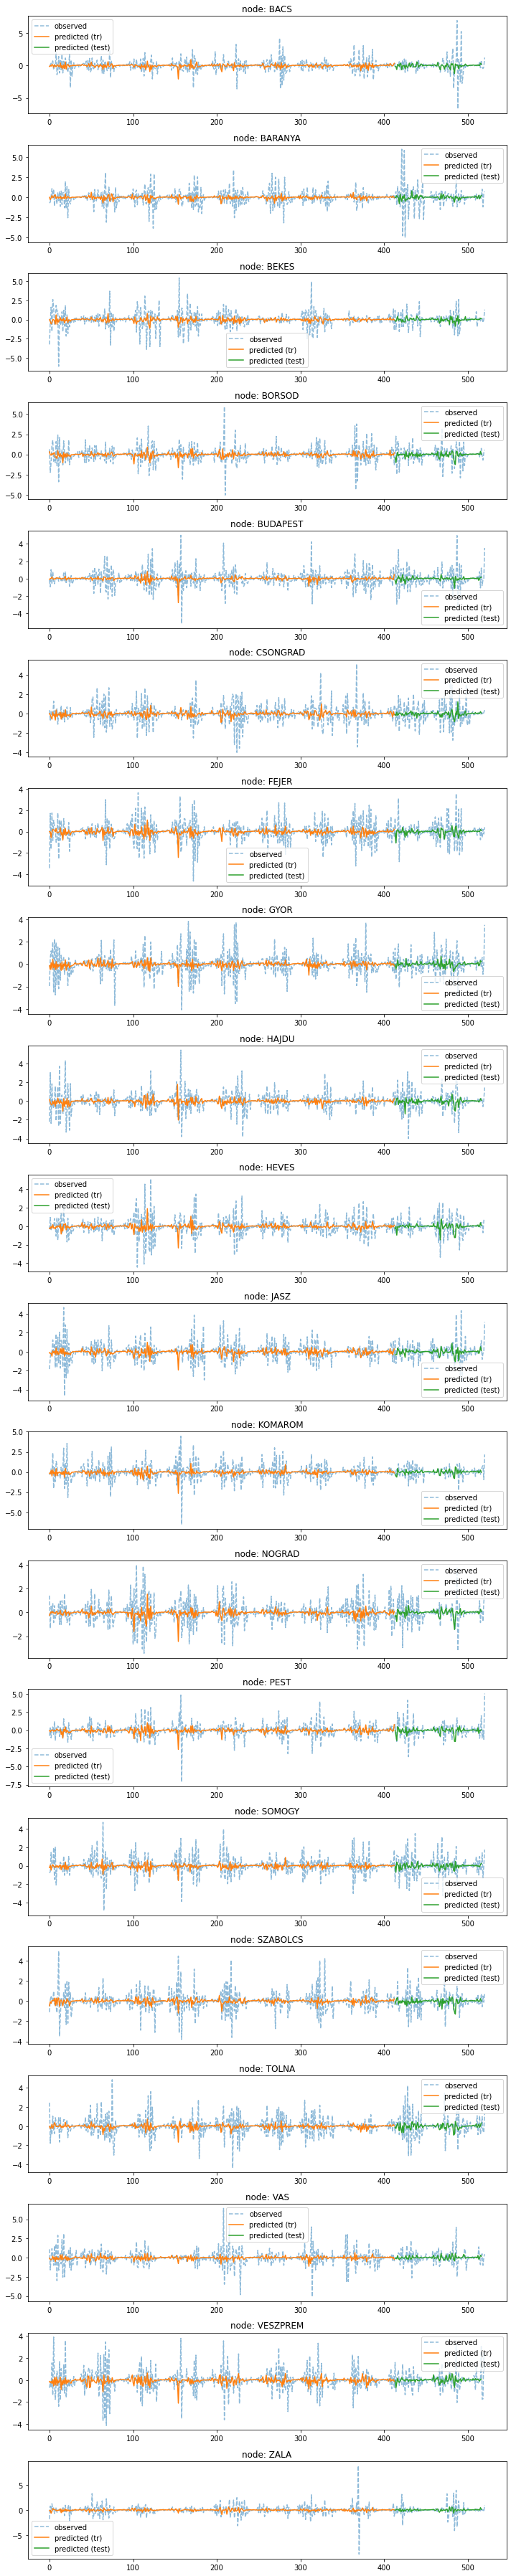

In [27]:
fig,ax = plt.subplots(20,1,figsize=(10,50))
for k in range(20):
    ax[k].plot(f[:,k],'--',alpha=0.5,label='observed')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:,k],label='predicted (tr)')
    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()
